In [1]:
import sys
import tensorflow.keras
import tensorflow as tf

print(f"tensorflow version : {tf.__version__}")
# print(f"keras version : {tensorflow.keras.__version__}")

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is " , "Available" if gpu else "NOT available")

tensorflow version : 2.13.0
GPU is  Available


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from sklearn.metrics import precision_score
from tensorflow.keras import regularizers
import shutil
import glob
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, AveragePooling2D, Flatten, Dense
from keras.layers import Conv2D , GlobalAveragePooling2D , MaxPooling2D,Dropout , Flatten , Dense, BatchNormalization, GlobalAvgPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
import tensorflow as tf
from tensorflow.keras.layers import GaussianNoise
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.python.framework.func_graph import flatten
from keras.callbacks import ModelCheckpoint , EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.models import Model , load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import  InceptionV3
from tensorflow.keras.applications.inception_v3 import  preprocess_input
from sklearn.model_selection import KFold
from keras.callbacks import Callback

In [3]:
import os

root_dir = "data"
number_of_images = {}

for dir in os.listdir(root_dir):
    # Ignore .DS_Store files
    if dir == '.DS_Store':
        continue

    # Check if the item is a directory before listing its contents
    if os.path.isdir(os.path.join(root_dir, dir)):
        number_of_images[dir] = len(os.listdir(os.path.join(root_dir, dir)))

print(number_of_images.items())


dict_items([('cat', 5000), ('dog', 5000), ('truck', 5000), ('bird', 5000), ('airplane', 5000), ('ship', 5000), ('frog', 5000), ('horse', 5000), ('deer', 5000), ('automobile', 5000)])


In [4]:
def foldercreation (path , split) :
    if not os.path.exists('./'+path):
      os.mkdir('./'+path)

      for dir in os.listdir(root_dir):
        if dir == '.DS_Store':
           continue
            
        os.makedirs('./'+path+"/"+dir)

        for img in np.random.choice(a=os.listdir(os.path.join(root_dir,dir)) , size = (math.floor(split * number_of_images[dir])-5) , replace=False):
          Original = os.path.join(root_dir,dir,img)
          Destination =os.path.join('./'+path , dir)
          shutil.copy(Original,Destination)
          # os.remove(Original)

    else:
      print("The folder exsist")

In [5]:
foldercreation("train_data",0.7)
foldercreation("validation_data",0.15)
foldercreation("test_data",0.15)

The folder exsist
The folder exsist
The folder exsist


In [6]:
image_data = ImageDataGenerator (
                                     
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      preprocessing_function= preprocess_input,
                                )

image=image_data.flow_from_directory(directory="train_data" ,
                                       target_size=(28,28),
                                       batch_size=32,
                                       shuffle=True,
                                       class_mode="categorical")

Found 34950 images belonging to 10 classes.


In [7]:
def preprocessing2 (path):
  image_data = ImageDataGenerator(preprocessing_function= preprocess_input)
  image = image_data.flow_from_directory(directory = path,
                                         target_size=(28,28),
                                         batch_size = 32,
                                         shuffle=True,
                                         class_mode = "categorical")
  return image

In [8]:
path_test ="test_data"
test_data = preprocessing2(path_test)
X_test , Y_test = test_data.next()

Found 7450 images belonging to 10 classes.


In [9]:
path_validate="validation_data"
validate_data = preprocessing2(path_validate)
validate_data_1 , validate_labels = validate_data.next()

Found 7450 images belonging to 10 classes.


In [10]:
def model_layer_1 (inputs,filters):


  convo_2x2 = Conv2D(filters=filters[0], kernel_size=(2,2), padding='same', activation='selu')(inputs)
  convo_3x3 = Conv2D(filters=filters[1], kernel_size=(3,3), padding='same', activation='selu')(inputs)
  pool_conv = Conv2D(filters=filters[2], kernel_size=(3,3), padding='same', activation='selu')(inputs)


  outputs = Concatenate(axis=-1)([convo_2x2, convo_3x3, pool_conv])

  return outputs


def model_layer_2 (inputs,filters):



  convo_3x3 = Conv2D(filters=filters[0], kernel_size=(2,2), padding='same', activation='selu')(inputs)
  pool_3x3 =MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same')(convo_3x3)

  convo_5x5 = Conv2D(filters=filters[1], kernel_size=(3,3), padding='same', activation='selu')(inputs)
  pool_5x5 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(convo_5x5)

  outputs = Concatenate(axis=-1)([pool_3x3, pool_5x5])

  return outputs


def model_layer_3 (inputs,filters):
    
  convo_1x1 = Conv2D(filters=filters[0], kernel_size=(3,3), padding='same', activation='selu')(inputs)
  pool_1x1 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(inputs)
  outputs = Concatenate(axis=-1)([pool_1x1, convo_1x1])

  return outputs


# def model_layer_5 (inputs,filters):
    
#   convo_1x1 = Conv2D(filters=filters[0], kernel_size=(5,5), padding='same', activation='relu')(inputs)
#   pool_1x1 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(inputs)
#   outputs = Concatenate(axis=-1)([pool_1x1, convo_1x1])

#   return outputs

# def model_layer_6 (inputs):
    
#   pool_3x3 = MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same')(inputs)
#   pool_1x1 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(inputs)
#   outputs = Concatenate(axis=-1)([pool_1x1, pool_3x3])

#   return outputs

    




In [11]:
from keras.layers import Input
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout

# define input tensor

input_tensor = Input(shape=(28, 28, 3))


original_model = model_layer_3(input_tensor,[128])
original_model = MaxPooling2D(pool_size=(2,2) ,padding='same')(original_model)


original_model = model_layer_1(original_model,[32,64,128])
original_model = MaxPooling2D(pool_size=(2,2),padding='same')(original_model)
original_model = model_layer_2(original_model,[128,64])

original_model = MaxPooling2D(pool_size=(2,2) ,padding='same')(original_model)
original_model = model_layer_3(original_model,[128])




2023-12-20 12:40:02.505513: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-12-20 12:40:02.505557: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-20 12:40:02.505569: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-20 12:40:02.505788: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-20 12:40:02.505810: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:

original_model = Flatten()(original_model)
original_model = Dense(512, activation='selu' ,kernel_regularizer=regularizers.l2(0.001))(original_model)
original_model = Dense(256, activation='selu' ,kernel_regularizer=regularizers.l2(0.001))(original_model)
original_model = Dropout(0.5)(original_model)

output_tensor = Dense(10, activation='softmax' ,kernel_regularizer=regularizers.l2(0.001))(original_model)

original_model = Model(inputs=input_tensor, outputs=output_tensor)

In [13]:
original_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 3)]          0         []                            
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 28, 28, 3)            0         ['input_1[0][0]']             
 D)                                                                                               
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 128)          3584      ['input_1[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 28, 28, 131)          0         ['max_pooling2d[0][0]',   

In [14]:
opt = keras.optimizers.Adam()
original_model.compile(optimizer= opt ,
              loss= keras.losses.categorical_crossentropy,
              metrics=['accuracy' , 'AUC'])

In [15]:
earlystop = EarlyStopping(monitor="accuracy",
                          min_delta=0.01 , patience=3,
                          verbose=1,
                          mode="auto")
modelcheckpoint = ModelCheckpoint(monitor="accuracy",
                                  filepath = "./selu.h5",
                                  verbose=1,
                                  save_best_only=True,
                                  mode ="auto"
                                  )
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-3)


class MetricsCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data[0], self.validation_data[1]
        predictions = self.model.predict(x_val)
        
        # Calculate top-5 accuracy
        top_5 = np.argsort(predictions, axis=1)[:, -5:]
        true_labels = np.argmax(y_val, axis=1)
        top_5_accuracy = np.mean([1 if true_label in pred_classes else 0 for true_label, pred_classes in zip(true_labels, top_5)])
        
        # Calculate precision
        precision = precision_score(true_labels, np.argmax(predictions, axis=1), average='weighted')
        
        print(f'Epoch {epoch + 1} - Top-5 Accuracy: {top_5_accuracy:.4f} - Precision: {precision:.4f}')


metrics_callback = MetricsCallback(validation_data=(validate_data_1, validate_labels))

callbs = [earlystop,modelcheckpoint,lr_scheduler,metrics_callback]

In [16]:
final = original_model.fit(
    image,
    steps_per_epoch=len(image),
    epochs=30,
    validation_data=(validate_data_1, validate_labels),
    validation_steps=len(validate_data_1),
    verbose=1,
    callbacks=callbs)
    

Epoch 1/30


2023-12-20 12:40:03.466617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1093/1093 [==============================] - ETA: 0s - loss: 2.6424 - accuracy: 0.3990 - auc: 0.8249

2023-12-20 12:42:51.253216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: accuracy improved from -inf to 0.39897, saving model to ./selu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 254ms/step
Epoch 1 - Top-5 Accuracy: 0.9688 - Precision: 0.5208
1093/1093 [==============================] - 171s 156ms/step - loss: 2.6424 - accuracy: 0.3990 - auc: 0.8249 - val_loss: 1.7908 - val_accuracy: 0.5000 - val_auc: 0.8931 - lr: 0.0010


2023-12-20 12:42:53.936985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/30
1093/1093 [==============================] - ETA: 0s - loss: 1.6993 - accuracy: 0.5261 - auc: 0.8972
Epoch 2: accuracy improved from 0.39897 to 0.52612, saving model to ./selu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 92ms/step
Epoch 2 - Top-5 Accuracy: 0.9375 - Precision: 0.7349
1093/1093 [==============================] - 169s 155ms/step - loss: 1.6993 - accuracy: 0.5261 - auc: 0.8972 - val_loss: 1.5361 - val_accuracy: 0.6562 - val_auc: 0.9163 - lr: 0.0010
Epoch 3/30


/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 1.5351 - accuracy: 0.5703 - auc: 0.9122
Epoch 3: accuracy improved from 0.52612 to 0.57027, saving model to ./selu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 125ms/step
Epoch 3 - Top-5 Accuracy: 0.9375 - Precision: 0.7542
1093/1093 [==============================] - 175s 160ms/step - loss: 1.5351 - accuracy: 0.5703 - auc: 0.9122 - val_loss: 1.2461 - val_accuracy: 0.7188 - val_auc: 0.9466 - lr: 0.0010
Epoch 4/30


/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 1.4289 - accuracy: 0.6058 - auc: 0.9228
Epoch 4: accuracy improved from 0.57027 to 0.60575, saving model to ./selu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 136ms/step
Epoch 4 - Top-5 Accuracy: 0.9688 - Precision: 0.7370
1093/1093 [==============================] - 188s 172ms/step - loss: 1.4289 - accuracy: 0.6058 - auc: 0.9228 - val_loss: 1.1897 - val_accuracy: 0.7188 - val_auc: 0.9505 - lr: 0.0010
Epoch 5/30


/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 1.3424 - accuracy: 0.6347 - auc: 0.9320
Epoch 5: accuracy improved from 0.60575 to 0.63474, saving model to ./selu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 81ms/step
Epoch 5 - Top-5 Accuracy: 1.0000 - Precision: 0.8812
1093/1093 [==============================] - 181s 165ms/step - loss: 1.3424 - accuracy: 0.6347 - auc: 0.9320 - val_loss: 0.8913 - val_accuracy: 0.7812 - val_auc: 0.9799 - lr: 0.0010
Epoch 6/30
1093/1093 [==============================] - ETA: 0s - loss: 1.2713 - accuracy: 0.6540 - auc: 0.9395
Epoch 6: accuracy improved from 0.63474 to 0.65399, saving model to ./selu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 79ms/step
Epoch 6 - Top-5 Accuracy: 0.9688 - Precision: 0.7375
1093/1093 [==============================] - 161s 147ms/step - loss: 1.2713 - accuracy: 0.6540 - auc: 0.9395 - val_loss: 1.3305 - val_accuracy: 0.6250 - val_auc: 0.9298 - lr: 0.0010
Epoch 7/30
1093/1093 [==============================] - ETA: 0s - loss: 1.2175 - accuracy: 0.6736 - auc: 0.9452
Epoch 7: accuracy improved from 0.65399 to 0.67356, saving model to ./selu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 79ms/step
Epoch 7 - Top-5 Accuracy: 1.0000 - Precision: 0.7503
1093/1093 [==============================] - 160s 146ms/step - loss: 1.2175 - accuracy: 0.6736 - auc: 0.9452 - val_loss: 1.1365 - val_accuracy: 0.7188 - val_auc: 0.9512 - lr: 0.0010
Epoch 8/30
1093/1093 [==============================] - ETA: 0s - loss: 1.1516 - accuracy: 0.6950 - auc: 0.9507
Epoch 8: accuracy improved from 0.67356 to 0.69499, saving model to ./selu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 58ms/step
Epoch 8 - Top-5 Accuracy: 1.0000 - Precision: 0.7771
1093/1093 [==============================] - 176s 161ms/step - loss: 1.1516 - accuracy: 0.6950 - auc: 0.9507 - val_loss: 1.1161 - val_accuracy: 0.7188 - val_auc: 0.9493 - lr: 0.0010
Epoch 9/30
1093/1093 [==============================] - ETA: 0s - loss: 1.1387 - accuracy: 0.7059 - auc: 0.9526
Epoch 9: accuracy improved from 0.69499 to 0.70589, saving model to ./selu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 124ms/step
Epoch 9 - Top-5 Accuracy: 1.0000 - Precision: 0.8396
1093/1093 [==============================] - 195s 179ms/step - loss: 1.1387 - accuracy: 0.7059 - auc: 0.9526 - val_loss: 0.9127 - val_accuracy: 0.7812 - val_auc: 0.9791 - lr: 0.0010
Epoch 10/30
1093/1093 [==============================] - ETA: 0s - loss: 1.1126 - accuracy: 0.7135 - auc: 0.9553
Epoch 10: accuracy improved from 0.70589 to 0.71353, saving model to ./selu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 47ms/step
Epoch 10 - Top-5 Accuracy: 1.0000 - Precision: 0.8646
1093/1093 [==============================] - 139s 127ms/step - loss: 1.1126 - accuracy: 0.7135 - auc: 0.9553 - val_loss: 1.1032 - val_accuracy: 0.7500 - val_auc: 0.9550 - lr: 0.0010
Epoch 11/30
1093/1093 [==============================] - ETA: 0s - loss: 1.0791 - accuracy: 0.7239 - auc: 0.9576
Epoch 11: accuracy improved from 0.71353 to 0.72389, saving model to ./selu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 82ms/step
Epoch 11 - Top-5 Accuracy: 1.0000 - Precision: 0.8396
1093/1093 [==============================] - 129s 118ms/step - loss: 1.0791 - accuracy: 0.7239 - auc: 0.9576 - val_loss: 0.7406 - val_accuracy: 0.8438 - val_auc: 0.9907 - lr: 0.0010
Epoch 12/30
   1/1093 [..............................] - ETA: 2:54 - loss: 1.1526 - accuracy: 0.7188 - auc: 0.9576

/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 1.0579 - accuracy: 0.7364 - auc: 0.9605
Epoch 12: accuracy improved from 0.72389 to 0.73642, saving model to ./selu.h5
1/1 [==============================] - 0s 44ms/step
Epoch 12 - Top-5 Accuracy: 1.0000 - Precision: 0.7979
1093/1093 [==============================] - 108s 99ms/step - loss: 1.0579 - accuracy: 0.7364 - auc: 0.9605 - val_loss: 0.8118 - val_accuracy: 0.7500 - val_auc: 0.9849 - lr: 0.0010
Epoch 13/30


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1093/1093 [==============================] - ETA: 0s - loss: 1.0428 - accuracy: 0.7417 - auc: 0.9615
Epoch 13: accuracy improved from 0.73642 to 0.74175, saving model to ./selu.h5
1/1 [==============================] - 0s 36ms/step
Epoch 13 - Top-5 Accuracy: 0.9688 - Precision: 0.7604
1093/1093 [==============================] - 83s 76ms/step - loss: 1.0428 - accuracy: 0.7417 - auc: 0.9615 - val_loss: 0.9412 - val_accuracy: 0.6875 - val_auc: 0.9757 - lr: 0.0010
Epoch 14/30


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 1.0247 - accuracy: 0.7479 - auc: 0.9637
Epoch 14: accuracy improved from 0.74175 to 0.74787, saving model to ./selu.h5
1/1 [==============================] - 0s 35ms/step
Epoch 14 - Top-5 Accuracy: 1.0000 - Precision: 0.7500
1093/1093 [==============================] - 84s 76ms/step - loss: 1.0247 - accuracy: 0.7479 - auc: 0.9637 - val_loss: 0.8419 - val_accuracy: 0.7812 - val_auc: 0.9816 - lr: 0.0010
Epoch 15/30


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 0.9804 - accuracy: 0.7588 - auc: 0.9663
Epoch 15: accuracy improved from 0.74787 to 0.75880, saving model to ./selu.h5
1/1 [==============================] - 0s 37ms/step
Epoch 15 - Top-5 Accuracy: 1.0000 - Precision: 0.6562
1093/1093 [==============================] - 68s 62ms/step - loss: 0.9804 - accuracy: 0.7588 - auc: 0.9663 - val_loss: 0.9404 - val_accuracy: 0.6875 - val_auc: 0.9753 - lr: 0.0010
Epoch 16/30


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 0.9870 - accuracy: 0.7620 - auc: 0.9661
Epoch 16: accuracy improved from 0.75880 to 0.76197, saving model to ./selu.h5
1/1 [==============================] - 0s 46ms/step
Epoch 16 - Top-5 Accuracy: 1.0000 - Precision: 0.8147
1093/1093 [==============================] - 83s 76ms/step - loss: 0.9870 - accuracy: 0.7620 - auc: 0.9661 - val_loss: 0.6550 - val_accuracy: 0.8438 - val_auc: 0.9945 - lr: 0.0010
Epoch 17/30


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 0.9666 - accuracy: 0.7668 - auc: 0.9674
Epoch 17: accuracy improved from 0.76197 to 0.76681, saving model to ./selu.h5
1/1 [==============================] - 0s 38ms/step
Epoch 17 - Top-5 Accuracy: 0.9688 - Precision: 0.7866
1093/1093 [==============================] - 89s 81ms/step - loss: 0.9666 - accuracy: 0.7668 - auc: 0.9674 - val_loss: 1.0455 - val_accuracy: 0.7188 - val_auc: 0.9714 - lr: 0.0010
Epoch 18/30


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1093/1093 [==============================] - ETA: 0s - loss: 0.9844 - accuracy: 0.7655 - auc: 0.9675
Epoch 18: accuracy did not improve from 0.76681
1/1 [==============================] - 0s 43ms/step
Epoch 18 - Top-5 Accuracy: 0.9688 - Precision: 0.7146
1093/1093 [==============================] - 90s 82ms/step - loss: 0.9844 - accuracy: 0.7655 - auc: 0.9675 - val_loss: 1.1726 - val_accuracy: 0.7188 - val_auc: 0.9562 - lr: 0.0010
Epoch 18: early stopping


/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
image.class_indices

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [18]:
import numpy as np
from sklearn.metrics import precision_score

def calculate_metrics(true_labels, predictions):
    # Calculate top-5 accuracy
    top_5 = np.argsort(predictions, axis=1)[:, -5:]
    top_5_accuracy = np.mean([1 if true_label in pred_classes else 0 for true_label, pred_classes in zip(true_labels, top_5)])

    # Calculate precision
    precision = precision_score(true_labels, np.argmax(predictions, axis=1), average='weighted')

    return top_5_accuracy, precision
    

In [19]:
prediction = original_model.evaluate(X_test , Y_test,verbose=1)
print('Test loss:', prediction[0])
print('Test accuracy:', prediction[1])

predictions = original_model.predict(X_test)
top_5_accuracy, precision = calculate_metrics(np.argmax(Y_test, axis=1), predictions)

# Print metrics
print(f' Top-5 Accuracy: {top_5_accuracy:.4f}')
print(f'Precision: {precision:.4f}')

2023-12-20 13:20:52.186491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 384ms/step - loss: 0.7047 - accuracy: 0.8125 - auc: 0.9894
Test loss: 0.7047008872032166
Test accuracy: 0.8125
1/1 [==============================] - 0s 46ms/step
 Top-5 Accuracy: 1.0000
Precision: 0.8578


/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


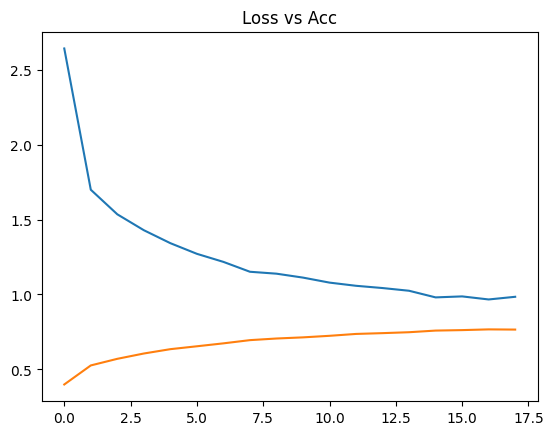

In [20]:
h = final.history
h.keys()



plt.plot(h['loss'])
plt.plot(h['accuracy'])

plt.title("Loss vs Acc")
plt.show()